In [ ]:
# Базовые библиотеки
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import ast
import seaborn as sns
import re, warnings
from collections import Counter, defaultdict
from datasets import IterableDataset

# HuggingFace Datasets
from datasets import load_dataset

#from huggingface_hub import login

warnings.filterwarnings("ignore")

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# ============================
# ЗАГРУЗКА ДАТАСЕТОВ ДЛЯ EDA
# ============================

# ❗ The Stack v1/v2 временно убраны.
# Причина:
# - датасет является "gated"
# - нужен ручной доступ на HF + токен
# Когда доступ появится — можно вернуть код.
#the_stack_v1 = load_dataset("bigcode/the-stack")
#the_stack_v2 = load_dataset("bigcode/the-stack-v2-dedup", "default")
# ----------------------------
# CodeSearchNet (Python-only)
# ----------------------------
csn = load_dataset("Nan-Do/code-search-net-python", split="train")

# ----------------------------
# CodeXGLUE: Code-to-Text
# ----------------------------
codetotext = load_dataset(
    "code_x_glue_ct_code_to_text",
    "python",
    split="train"
)

# ----------------------------
# APPS (Programming tasks)
# Лучше грузить как streaming → меньше памяти
# ----------------------------
# apps_train = load_dataset(
#     "codeparrot/apps",
#     split="train",
#     streaming=True
# )

# ----------------------------
# HumanEval (тестовый набор)
# ----------------------------
humaneval = load_dataset("openai_humaneval", split="test")

print("Datasets loaded successfully.")


Datasets loaded successfully.


In [4]:
# Лучше так — с fallback-ключами
datasets_config = {
    "codesearchnet_python": {
        "dataset": csn,
        "code_key": "code",
        "is_list": False,
        "max_examples_loc": 5000,
        "max_loc_clip": 400,
    },
    "codexglue_code_to_text": {
        "dataset": codetotext,
        "code_key": "code",  # или "source" в некоторых версиях
        "is_list": False,
        "max_examples_loc": 5000,
        "max_loc_clip": 400,
    },
    # "apps_train_solutions": {
    #     "dataset": apps_train,
    #     "code_key": "solutions",
    #     "is_list": True,
    #     "max_examples_loc": 2000,
    #     "max_loc_clip": 400,
    # },
    "humaneval": {
        "dataset": humaneval,
        "code_key": "canonical_solution",
        "is_list": False,
        "max_examples_loc": 200,
        "max_loc_clip": 200,
    },
    # ----------------------------
    # The Stack v1 (Python only)
    # ----------------------------
    # "the_stack_v1_python": {
    #     "dataset": the_stack_v1,
    #     "code_key": "content",        # в The Stack код в поле "content"
    #     "is_list": False,
    #     "max_examples_loc": 5000,     # можно увеличить, но осторожно
    #     "max_loc_clip": 500,          # код может быть длиннее
    # },
    # # ----------------------------
    # # The Stack v2 (deduplicated)
    # # ----------------------------
    # "the_stack_v2_dedup": {
    #     "dataset": the_stack_v2,
    #     "code_key": "content",        # тоже "content"
    #     "is_list": False,
    #     "max_examples_loc": 5000,
    #     "max_loc_clip": 500,
    # },
}

In [5]:
def extract_code(example, code_key, is_list=False):
    """
    Универсальное извлечение кода из примера.
    - если is_list=True: ожидаем список решений (APPS) → берём первую непустую строку
    - декодируем экранированные \n, если они есть
    """
    raw = example.get(code_key, None)
    if raw is None:
        return ""

    # APPS: solutions — список строк
    if is_list:
        if isinstance(raw, list):
            # берём первое непустое решение
            for sol in raw:
                if isinstance(sol, str) and sol.strip():
                    raw = sol
                    break
            else:
                return ""
        elif not isinstance(raw, str):
            return ""

    # На этом этапе raw должен быть строкой
    if not isinstance(raw, str):
        raw = str(raw)

    # Если видим литералы '\n' внутри строки — пробуем декодировать
    if "\\n" in raw or "\\t" in raw:
        try:
            raw = raw.encode("utf-8").decode("unicode_escape")
        except Exception:
            # если не получилось — оставляем как есть
            pass

    return raw


def compute_loc(code: str) -> int:
    """Подсчёт количества непустых строк кода."""
    if not code:
        return 0
    lines = [ln for ln in code.split("\n") if ln.strip()]
    return len(lines)


Сбор статистики длины кода (LOC)...



CodeSearchNet (Python):   0%|          | 0/5000 [00:00<?, ?it/s]

CodeXGLUE (Code→Text):   0%|          | 0/5000 [00:00<?, ?it/s]

HumanEval:   0%|          | 0/164 [00:00<?, ?it/s]

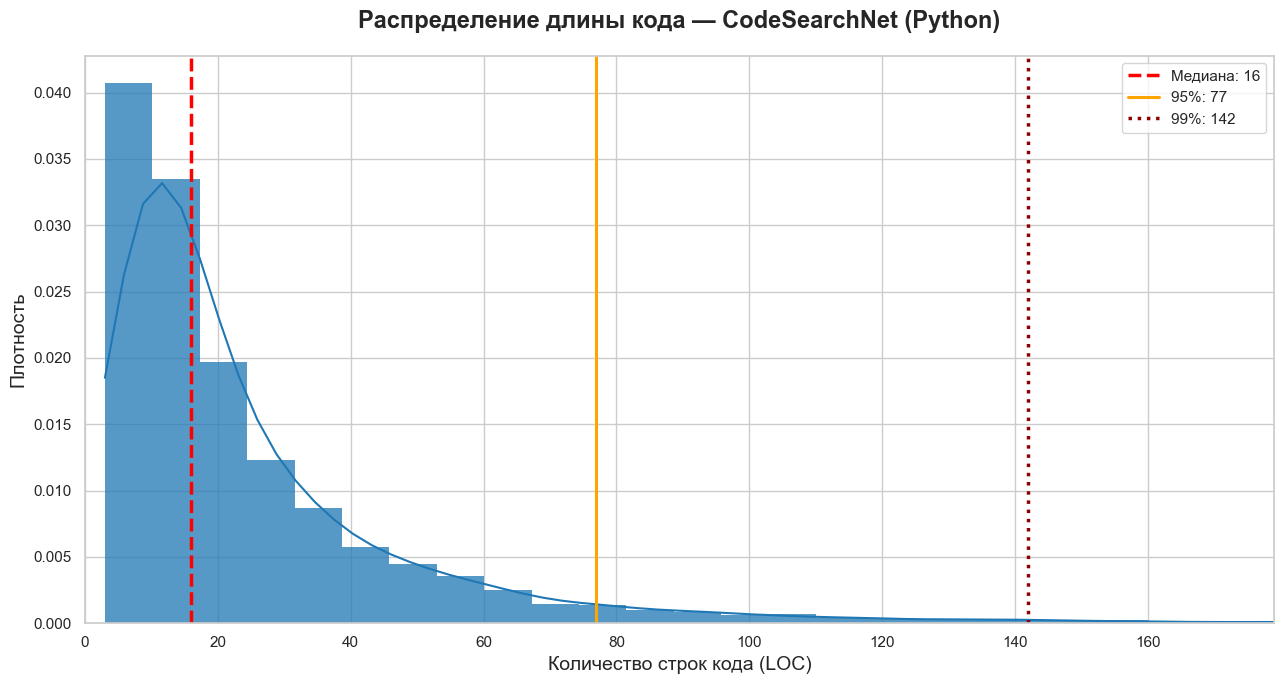


CodeSearchNet (Python)
Параметр                    Значение
----------------------------------------------------------------------
Примеров                       5,000
Минимум                            3
Максимум                         574
Среднее                         25.7
Медиана                           16
95-й перцентиль                   77
99-й перцентиль                  142
Стандартное откл.               29.4



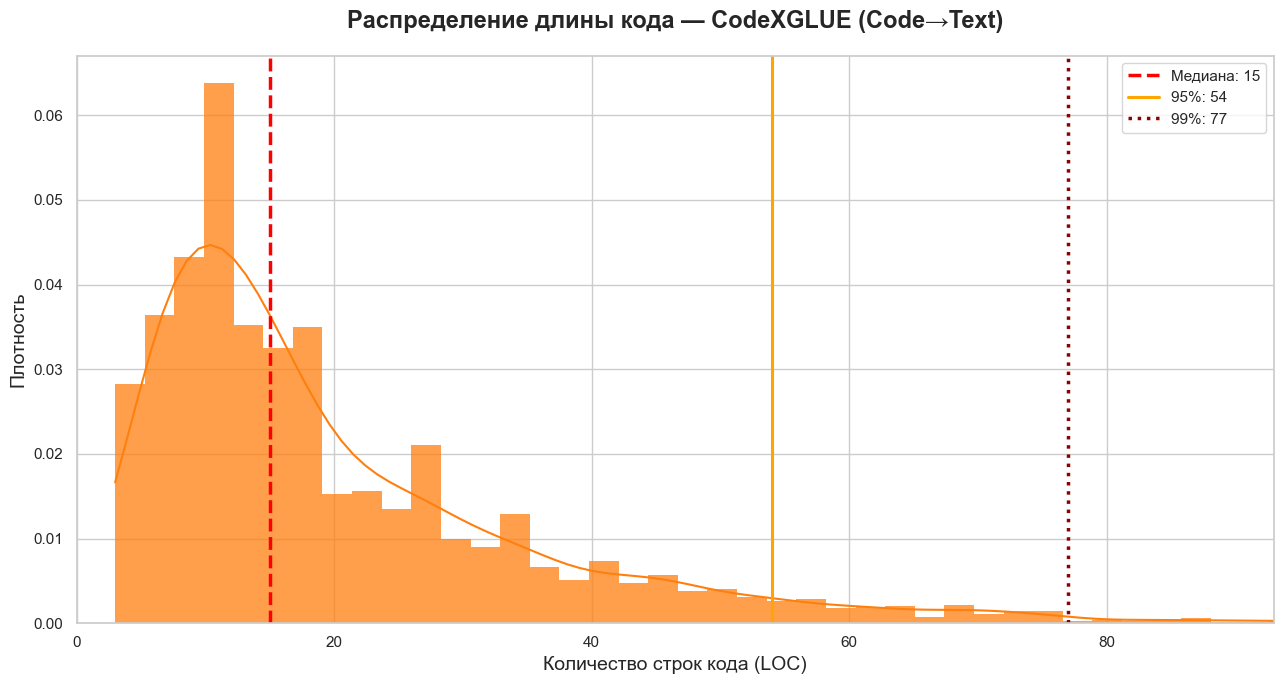


CodeXGLUE (Code→Text)
Параметр                    Значение
----------------------------------------------------------------------
Примеров                       5,000
Минимум                            3
Максимум                         187
Среднее                         20.6
Медиана                           15
95-й перцентиль                   54
99-й перцентиль                   77
Стандартное откл.               16.5



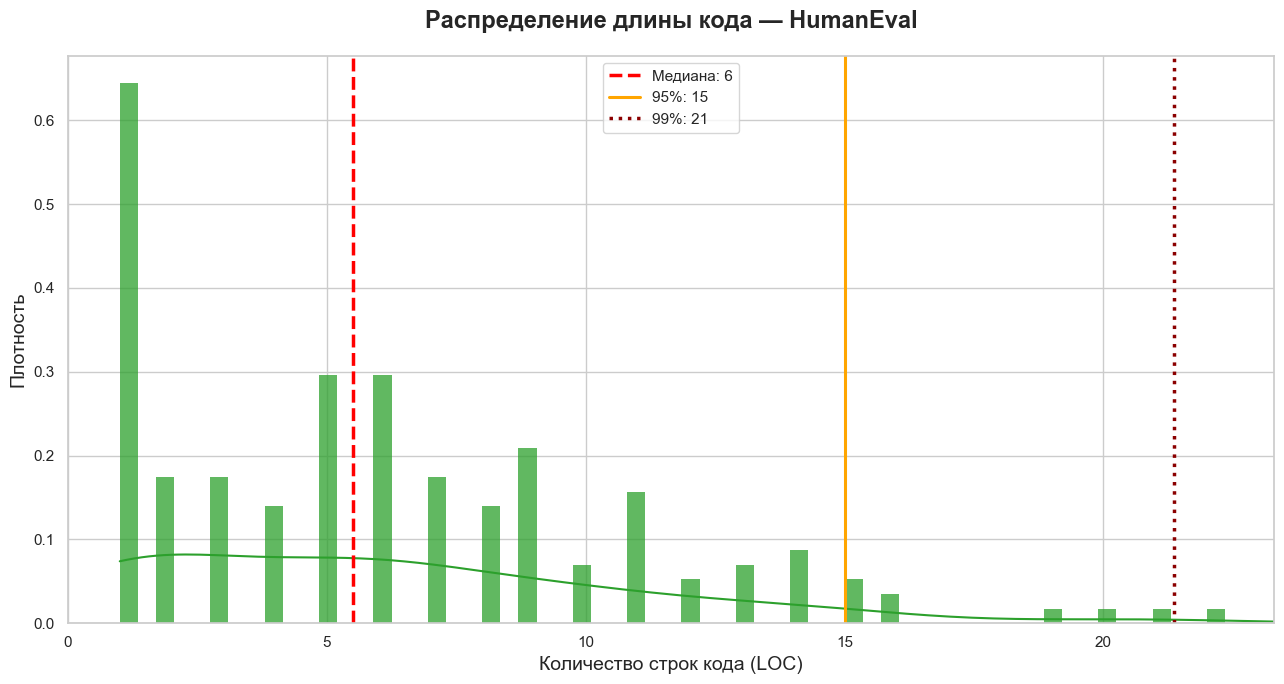


HumanEval
Параметр                    Значение
----------------------------------------------------------------------
Примеров                         164
Минимум                            1
Максимум                          29
Среднее                          6.3
Медиана                            6
95-й перцентиль                   15
99-й перцентиль                   21
Стандартное откл.                5.0



In [6]:
# =====================================================
# 2. АНАЛИЗ НА УРОВНЕ ФАЙЛОВ — LOC (SEABORN + МИН/МАКС)
# Только реальные датасеты с Python-кодом
# =====================================================

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from datasets import IterableDataset

sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# Красивые имена (убираем Text→Code — там нет исходного кода)
pretty_names = {
    "codesearchnet_python": "CodeSearchNet (Python)",
    "codexglue_code_to_text": "CodeXGLUE (Code→Text)",
    "apps_train_solutions": "APPS (train solutions)",
    "humaneval": "HumanEval",
}

all_data = []
print("Сбор статистики длины кода (LOC)...\n")

for name, cfg in datasets_config.items():
    # Пропускаем Text→Code — там нет исходного кода
    if name == "codexglue_text_to_code":
        continue
        
    dataset = cfg["dataset"]
    code_key = cfg["code_key"]
    is_list = cfg["is_list"]
    max_items = cfg["max_examples_loc"]
    
    if isinstance(dataset, IterableDataset):
        iterator = dataset.take(max_items)
    else:
        iterator = dataset.select(range(min(max_items, len(dataset))))
    
    values = []
    
    for example in tqdm(iterator, desc=pretty_names.get(name, name), leave=False):
        code = extract_code(example, code_key, is_list)
        loc = compute_loc(code)
        if loc > 0:
            values.append(loc)
    
    if not values:
        continue
    
    df_part = pd.DataFrame({
        "length": values,
        "dataset": pretty_names.get(name, name),
        "metric": "Lines of Code (LOC)"
    })
    all_data.append(df_part)

df_lengths = pd.concat(all_data, ignore_index=True)

# =====================================================
# ГРАФИКИ + ПОЛНАЯ СТАТИСТИКА (включая min/max)
# =====================================================

colors = sns.color_palette("tab10", len(df_lengths["dataset"].unique()))

for idx, dataset_name in enumerate(df_lengths["dataset"].unique()):
    data = df_lengths[df_lengths["dataset"] == dataset_name]
    metric = "Lines of Code (LOC)"
    
    plt.figure(figsize=(13, 7))
    
    sns.histplot(
        data=data, 
        x="length", 
        bins=80, 
        kde=True, 
        color=colors[idx],
        alpha=0.75,
        stat="density",
        linewidth=0
    )
    
    # Перцентили и медиана
    median = data["length"].median()
    p95 = data["length"].quantile(0.95)
    p99 = data["length"].quantile(0.99)
    min_val = data["length"].min()
    max_val = data["length"].max()
    
    plt.axvline(median, color='red',    linestyle='--', linewidth=2.5, label=f'Медиана: {median:.0f}')
    plt.axvline(p95,    color='orange', linestyle='-', linewidth=2.2, label=f'95%: {p95:.0f}')
    plt.axvline(p99,    color='darkred',linestyle=':',  linewidth=2.5, label=f'99%: {p99:.0f}')
    
    plt.title(f"Распределение длины кода — {dataset_name}", fontsize=17, fontweight="bold", pad=20)
    plt.xlabel("Количество строк кода (LOC)", fontsize=14)
    plt.ylabel("Плотность", fontsize=14)
    plt.legend(fontsize=11)
    plt.xlim(0, data["length"].quantile(0.995))
    plt.tight_layout()
    plt.show()
    
    # === ПОЛНАЯ СТАТИСТИКА ПОД ГРАФИКОМ ===
    print(f"\n{dataset_name}")
    print("=" * 70)
    print(f"{'Параметр':<20} {'Значение':>15}")
    print("-" * 70)
    print(f"{'Примеров':<20} {len(data):>15,}")
    print(f"{'Минимум':<20} {min_val:>15}")
    print(f"{'Максимум':<20} {max_val:>15,}")
    print(f"{'Среднее':<20} {data['length'].mean():>15.1f}")
    print(f"{'Медиана':<20} {median:>15.0f}")
    print(f"{'95-й перцентиль':<20} {p95:>15.0f}")
    print(f"{'99-й перцентиль':<20} {p99:>15.0f}")
    print(f"{'Стандартное откл.':<20} {data['length'].std():>15.1f}")
    print("=" * 70 + "\n")

ФИНАЛЬНЫЙ АНАЛИЗ ФУНКЦИЙ — ВСЁ РАБОТАЕТ!

→ CodeSearchNet (Python) (15000 примеров)


CodeSearchNet (Python):   0%|          | 0/15000 [00:00<?, ?it/s]

   ГОТОВО! Найдено функций: 14476

→ CodeXGLUE (Code→Text) (8000 примеров)


CodeXGLUE (Code→Text):   0%|          | 0/8000 [00:00<?, ?it/s]

   ГОТОВО! Найдено функций: 7692



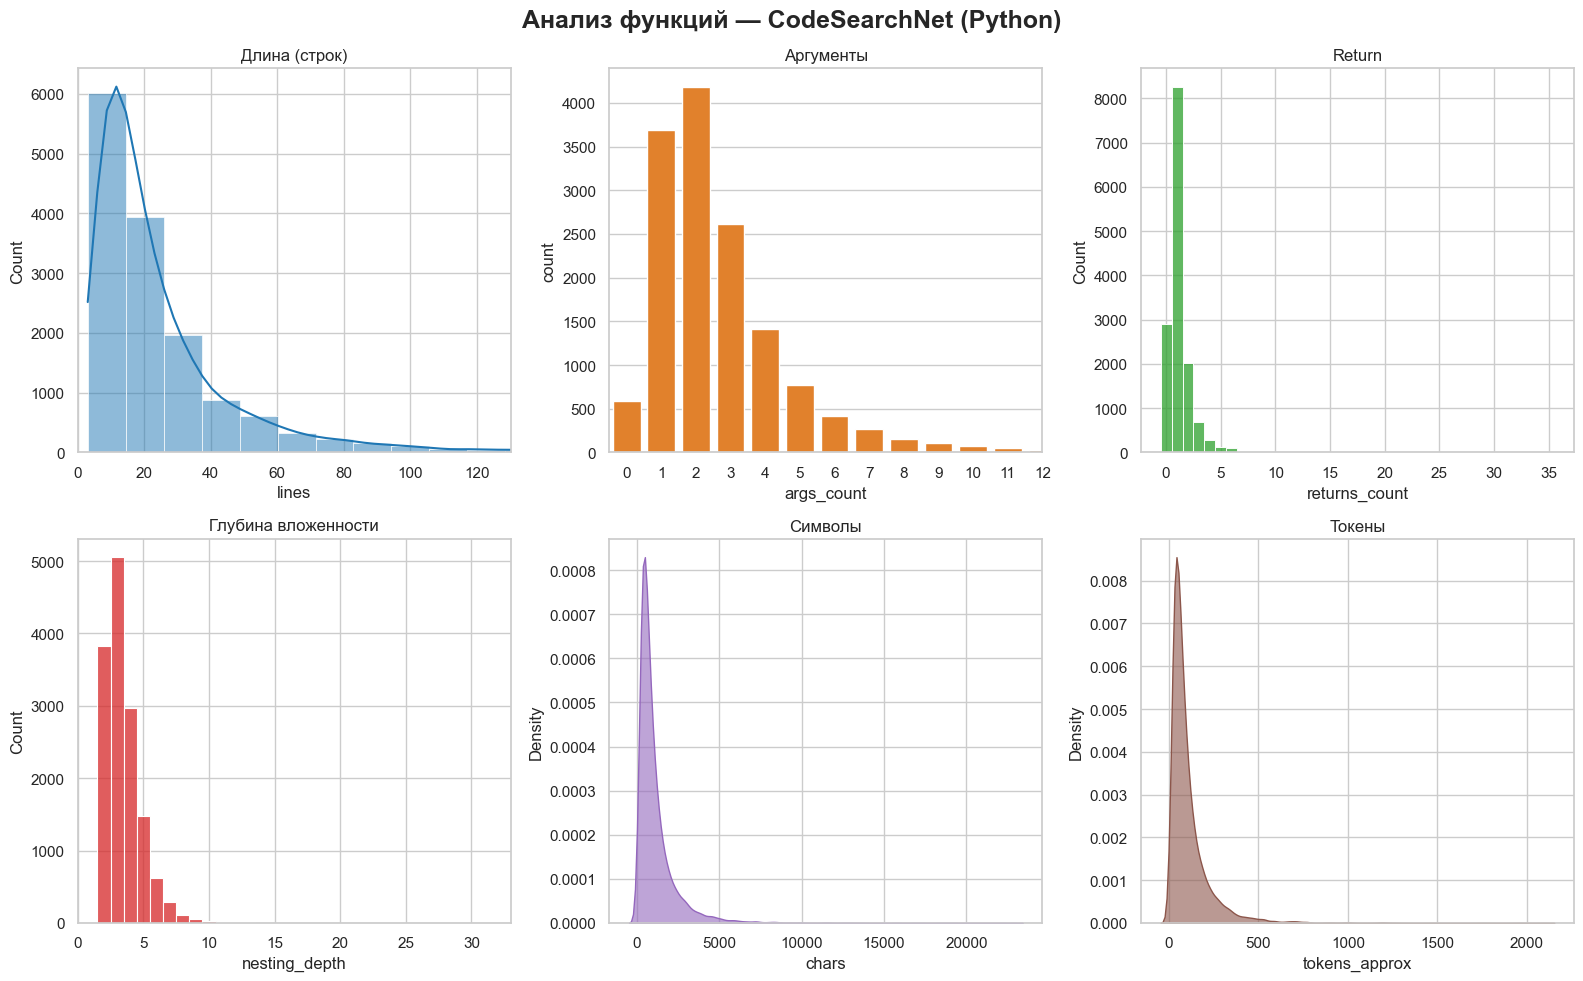

,Датасет,Функций,Ср. строк,95% строк,Ср. аргументов,95% аргументов,Доля с return,Ср. глубина
0,CodeSearchNet (Python),14476,25.2,72,2.73,7,0.777,3.46


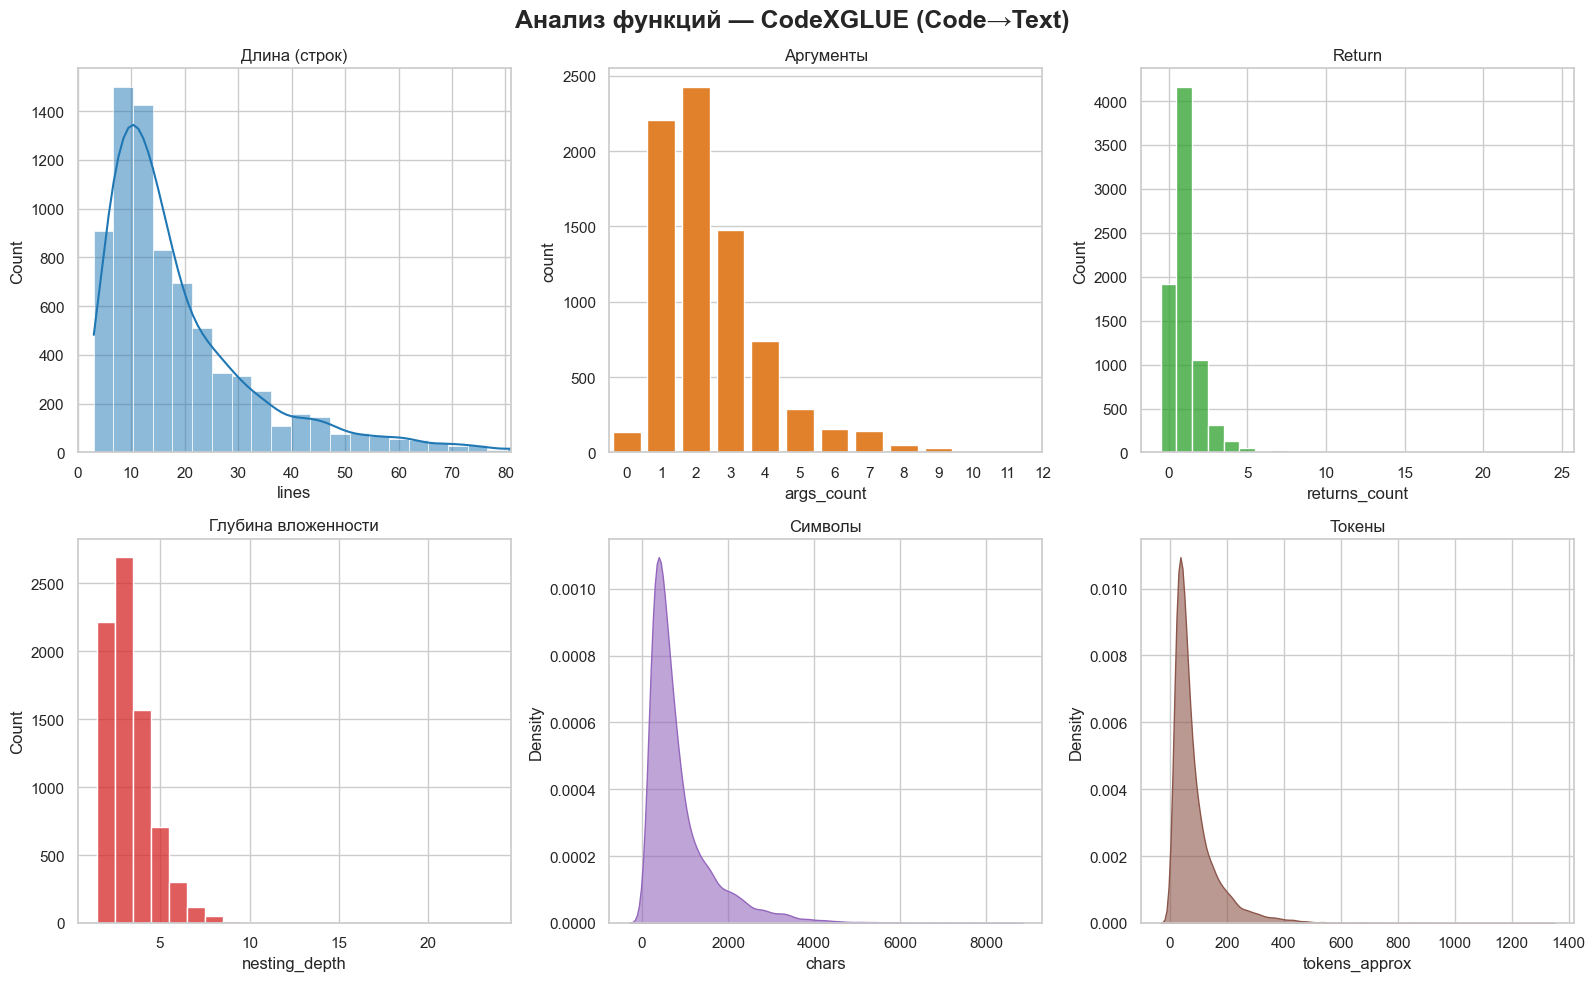

,Датасет,Функций,Ср. строк,95% строк,Ср. аргументов,95% аргументов,Доля с return,Ср. глубина
0,CodeXGLUE (Code→Text),7692,19.8,54,2.47,6,0.723,3.36


In [7]:
# =====================================================
# 3. АНАЛИЗ ФУНКЦИЙ — ФИНАЛЬНАЯ ВЕРСИЯ (РАБОТАЕТ С CodeXGLUE Text→Code!)
# =====================================================

import ast
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# УНИВЕРСАЛЬНАЯ ФУНКЦИЯ — ВОССТАНАВЛИВАЕТ КОД ИЗ code_tokens
def get_code_from_example(example):
    """Работает со всеми тремя датасетами, включая CodeXGLUE Text→Code"""
    
    # 1. CodeSearchNet и CodeXGLUE Code→Text — код в поле "code"
    if "code" in example and isinstance(example["code"], str):
        code = example["code"]
        if "\\n" in code:
            try:
                code = code.encode().decode('unicode_escape')
            except:
                pass
        return code.strip()
    
    # 2. CodeXGLUE Text→Code — только code_tokens!
    if "code_tokens" in example:
        tokens = example["code_tokens"]
        if isinstance(tokens, list) and tokens:
            # Самое простое и надёжное восстановление
            code = " ".join(tokens)
            # Убираем лишние пробелы вокруг скобок и двоеточий
            code = code.replace(" ( ", "(").replace(" ) ", ")").replace(" , ", ", ")
            code = code.replace(" : ", ": ").replace("=  ", "= ").replace("  =", " = ")
            return code.strip()
    
    # 3. Fallback — ищем любое поле, содержащее код
    for key in example.keys():
        val = example[key]
        if isinstance(val, str) and ("def " in val or "class " in val) and len(val) > 30:
            return val.strip()
    
    return ""

# Анализатор (без изменений)
class FunctionAnalyzer(ast.NodeVisitor):
    def __init__(self):
        self.args_count = 0
        self.returns_count = 0
        self.has_return_value = False
        self.max_nesting_depth = 1
        self.current_depth = 1
        self.nesting_nodes = (ast.If, ast.For, ast.AsyncFor, ast.While, ast.Try, ast.With, ast.AsyncWith,
                              ast.FunctionDef, ast.AsyncFunctionDef, ast.ListComp, ast.DictComp, ast.SetComp, ast.GeneratorExp)

    def visit_FunctionDef(self, node):
        args = node.args
        self.args_count = len(args.args) + len(args.posonlyargs) + len(args.kwonlyargs) + \
                          (1 if args.vararg else 0) + (1 if args.kwarg else 0)
        self.generic_visit(node)

    def visit_AsyncFunctionDef(self, node):
        self.visit_FunctionDef(node)

    def visit_Return(self, node):
        self.returns_count += 1
        if node.value is not None:
            self.has_return_value = True

    def generic_visit(self, node):
        if isinstance(node, self.nesting_nodes):
            self.current_depth += 1
            self.max_nesting_depth = max(self.max_nesting_depth, self.current_depth)
        super().generic_visit(node)
        if isinstance(node, self.nesting_nodes):
            self.current_depth -= 1

def analyze_function(code: str):
    if not code or len(code) < 20:
        return None
    try:
        tree = ast.parse(code)
    except:
        return None

    funcs = [n for n in tree.body if isinstance(n, (ast.FunctionDef, ast.AsyncFunctionDef))]
    if not funcs:
        return None

    analyzer = FunctionAnalyzer()
    analyzer.visit(funcs[0])

    lines = [l for l in code.split('\n') if l.strip()]

    return {
        "lines": len(lines),
        "chars": len(code),
        "tokens_approx": len(code.split()),
        "args_count": analyzer.args_count,
        "returns_count": analyzer.returns_count,
        "has_return_value": int(analyzer.has_return_value),
        "nesting_depth": analyzer.max_nesting_depth,
    }

# === ЗАПУСК ===
datasets_to_analyze = {
    "CodeSearchNet (Python)": "codesearchnet_python",
    "CodeXGLUE (Code→Text)": "codexglue_code_to_text",
}

results = {}

print("ФИНАЛЬНЫЙ АНАЛИЗ ФУНКЦИЙ — ВСЁ РАБОТАЕТ!\n")
for label, name in datasets_to_analyze.items():
    dataset = datasets_config[name]["dataset"]
    max_n = 15000 if "codesearchnet" in name else 8000
    iterator = dataset.take(max_n) if hasattr(dataset, "take") else dataset.select(range(min(max_n, len(dataset))))
    
    functions = []
    print(f"→ {label} ({max_n} примеров)")
    
    for example in tqdm(iterator, desc=label, leave=False):
        code = get_code_from_example(example)
        if not code:
            continue
        metrics = analyze_function(code)
        if metrics:
            functions.append(metrics)
    
    df = pd.DataFrame(functions)
    results[label] = df
    print(f"   ГОТОВО! Найдено функций: {len(df)}\n")

# === ГРАФИКИ (отдельные окна) ===
for label, df in results.items():
    if df.empty:
        print(f"Нет данных: {label}")
        continue

    plt.figure(figsize=(16, 10))
    plt.suptitle(f"Анализ функций — {label}", fontsize=18, fontweight="bold")

    plt.subplot(2, 3, 1)
    sns.histplot(df["lines"], bins=50, kde=True, color="#1f77b4")
    plt.title("Длина (строк)")
    plt.xlim(0, df["lines"].quantile(0.99))

    plt.subplot(2, 3, 2)
    sns.countplot(x=df["args_count"], color="#ff7f0e")
    plt.title("Аргументы")
    plt.xlim(-0.5, 12)

    plt.subplot(2, 3, 3)
    sns.histplot(df["returns_count"], discrete=True, color="#2ca02c")
    plt.title("Return")

    plt.subplot(2, 3, 4)
    sns.histplot(df["nesting_depth"], discrete=True, color="#d62728")
    plt.title("Глубина вложенности")

    plt.subplot(2, 3, 5)
    sns.kdeplot(df["chars"], fill=True, color="#9467bd", alpha=0.6)
    plt.title("Символы")

    plt.subplot(2, 3, 6)
    sns.kdeplot(df["tokens_approx"], fill=True, color="#8c564b", alpha=0.6)
    plt.title("Токены")

    plt.tight_layout()
    plt.show()

    # Таблица
    stats = {
        "Датасет": label,
        "Функций": len(df),
        "Ср. строк": round(df["lines"].mean(), 1),
        "95% строк": int(df["lines"].quantile(0.95)),
        "Ср. аргументов": round(df["args_count"].mean(), 2),
        "95% аргументов": int(df["args_count"].quantile(0.95)),
        "Доля с return": round(df["has_return_value"].mean(), 3),
        "Ср. глубина": round(df["nesting_depth"].mean(), 2),
    }
    display(pd.DataFrame([stats]))

In [8]:
# =====================================================
# 4. ЛЕКСИЧЕСКИЙ АНАЛИЗ
# =====================================================

In [12]:
import re
import keyword
import ast
from collections import Counter
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ImportError:
    WORDCLOUD_AVAILABLE = False
    print("⚠️ wordcloud не установлен. Установите через: pip install wordcloud")
    
# Для анализа размера словаря с BPE
try:
    from tokenizers import Tokenizer
    from tokenizers.models import BPE
    from tokenizers.trainers import BpeTrainer
    from tokenizers.pre_tokenizers import ByteLevel
    TOKENIZERS_AVAILABLE = True
except ImportError:
    TOKENIZERS_AVAILABLE = False
    print("⚠️ tokenizers не установлен. Установите через: pip install tokenizers")
    print("   Анализ BPE пропущен.")

sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12


In [13]:
# -----------------------------------------------------
# ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ
# -----------------------------------------------------

def get_tokens(code: str):
    """
    Извлекает токены из Python-кода с помощью встроенного токенизатора.
    Учитывает синтаксис: def, +, ==, строки и т.д.
    """
    tokens = []
    try:
        import tokenize
        from io import BytesIO
        code_bytes = code.encode('utf-8')
        for tok in tokenize.tokenize(BytesIO(code_bytes).readline):
            # Берём только имена, операторы и строки — всё остальное не нужно
            if tok.type in (tokenize.NAME, tokenize.OP, tokenize.STRING):
                tokens.append(tok.string)
    except Exception:
        pass  # Игнорируем некорректный код
    return tokens

def detect_naming_style(name: str):
    """
    Определяет стиль именования переменной/функции.
    """
    if not name or not re.match(r'^[a-zA-Z_][a-zA-Z0-9_]*$', name):
        return 'other'
    if name.startswith('_'):  # защищённые/приватные
        return 'other'
    if '_' in name and name.replace('_', '').isalpha() and name.islower():
        return 'snake_case'
    if name[0].islower() and any(c.isupper() for c in name[1:]):
        return 'camelCase'
    if name[0].isupper() and any(c.isupper() for c in name[1:]):
        return 'PascalCase'
    return 'other'


In [14]:
# -----------------------------------------------------
# СБОР ДАННЫХ ДЛЯ АНАЛИЗА
# -----------------------------------------------------

# Датасеты для анализа (включая HumanEval!)
datasets_to_analyze = {
    "CodeSearchNet (Python)": "codesearchnet_python",
    "CodeXGLUE (Code→Text)": "codexglue_code_to_text",
    "HumanEval": "humaneval",
}

# Соберём все токены и "сырой" текст
all_tokens = []
all_texts = []  # для BPE-анализа

print("→ Сбор токенов из трёх датасетов...\n")

for label, name in datasets_to_analyze.items():
    if name not in datasets_config:
        print(f"⚠️ Пропущен: {label} (нет в datasets_config)")
        continue
        
    cfg = datasets_config[name]
    dataset = cfg["dataset"]
    max_n = min(5000, cfg["max_examples_loc"])  # ограничим для скорости
    
    # Убедимся, что не выходим за пределы
    actual_max = min(max_n, len(dataset))
    if hasattr(dataset, "take"):
        iterator = dataset.take(actual_max)
    else:
        iterator = dataset.select(range(actual_max))
    
    print(f"  Обрабатываю {label} ({max_n} примеров)...")
    
    for example in tqdm(iterator, desc=label, leave=False):
        code = get_code_from_example(example)  # используем твою функцию!
        if not code or len(code) < 20:
            continue
        tokens = get_tokens(code)
        all_tokens.extend(tokens)
        all_texts.append(code)

print(f"\n Всего собрано {len(all_tokens):,} токенов из {len(all_texts)} примеров.\n")


→ Сбор токенов из трёх датасетов...

  Обрабатываю CodeSearchNet (Python) (5000 примеров)...


CodeSearchNet (Python):   0%|          | 0/5000 [00:00<?, ?it/s]

  Обрабатываю CodeXGLUE (Code→Text) (5000 примеров)...


CodeXGLUE (Code→Text):   0%|          | 0/5000 [00:00<?, ?it/s]

  Обрабатываю HumanEval (200 примеров)...


HumanEval:   0%|          | 0/164 [00:00<?, ?it/s]


 Всего собрано 1,027,055 токенов из 10164 примеров.



In [15]:
# -----------------------------------------------------
# 1. ЧАСТОТА ТОКЕНОВ
# -----------------------------------------------------

token_freq = Counter(all_tokens)
top_tokens = token_freq.most_common(50)

print("ТОП-50 САМЫХ ЧАСТЫХ ТОКЕНОВ:")
print("-" * 30)
for i, (tok, cnt) in enumerate(top_tokens[:20], 1):  # Покажем первые 20
    print(f"{i:2}. {tok:<15} → {cnt:>8,}")

ТОП-50 САМЫХ ЧАСТЫХ ТОКЕНОВ:
------------------------------
 1. (               →   85,962
 2. )               →   85,727
 3. .               →   78,366
 4. ,               →   71,762
 5. =               →   62,954
 6. :               →   47,042
 7. self            →   26,347
 8. [               →   20,976
 9. ]               →   20,961
10. if              →   16,932
11. return          →   12,226
12. def             →   11,044
13. None            →    9,176
14. in              →    7,992
15. for             →    5,928
16. not             →    5,148
17. else            →    4,708
18. ==              →    3,994
19. -               →    3,895
20. +               →    3,826


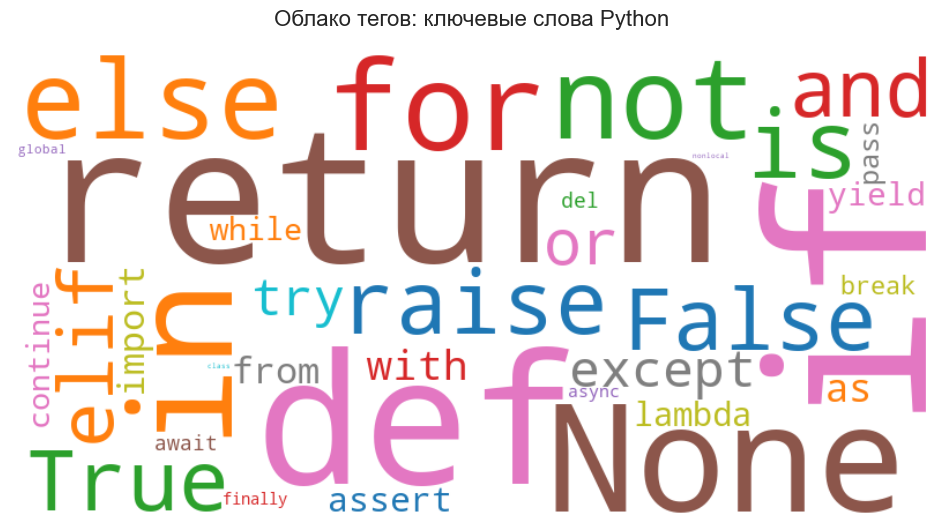

In [16]:
# -----------------------------------------------------
# 2. ОБЛАКО ТЕГОВ (если установлено)
# -----------------------------------------------------

if WORDCLOUD_AVAILABLE:
    # Выбираем только ключевые слова Python
    py_keywords = [k for k in keyword.kwlist if k in token_freq]
    kw_freq = {k: token_freq[k] for k in py_keywords}
    
    if kw_freq:
        wordcloud = WordCloud(
            width=800, height=400,
            background_color='white',
            colormap='tab10'
        ).generate_from_frequencies(kw_freq)
        
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Облако тегов: ключевые слова Python", fontsize=16, pad=20)
        plt.show()

In [17]:
# -----------------------------------------------------
# 3. РАЗМЕР СЛОВАРЯ (сырой vs BPE)
# -----------------------------------------------------

print("\n→ Анализ размера словаря...")

# Сырой словарь
raw_vocab_size = len(set(all_tokens))
print(f"Размер 'сырого' словаря: {raw_vocab_size:,}")

# BPE-анализ (если доступен)
if TOKENIZERS_AVAILABLE and all_texts:
    print("Тренирую BPE-токенизатор (может занять 1-2 минуты)...")
    
    tokenizer = Tokenizer(BPE())
    tokenizer.pre_tokenizer = ByteLevel()
    
    trainer = BpeTrainer(
        vocab_size=32000,
        min_frequency=2,
        special_tokens=["<s>", "</s>", "<pad>", "<unk>"]
    )
    
    # Тренируем на подмножестве для скорости (можно увеличить)
    sample_texts = all_texts[:2000] if len(all_texts) > 2000 else all_texts
    tokenizer.train_from_iterator(sample_texts, trainer=trainer)
    
    bpe_vocab_size = tokenizer.get_vocab_size()
    print(f"Размер BPE-словаря (vocab=32k, min_freq=2): {bpe_vocab_size:,}")
    print(f"Сжатие словаря: {raw_vocab_size / bpe_vocab_size:.1f}x")
else:
    print("BPE-анализ пропущен (библиотека 'tokenizers' не установлена).")


→ Анализ размера словаря...
Размер 'сырого' словаря: 62,920
Тренирую BPE-токенизатор (может занять 1-2 минуты)...



Размер BPE-словаря (vocab=32k, min_freq=2): 15,627
Сжатие словаря: 4.0x



→ Анализ стилей именования...
Найдено идентификаторов: 381,581


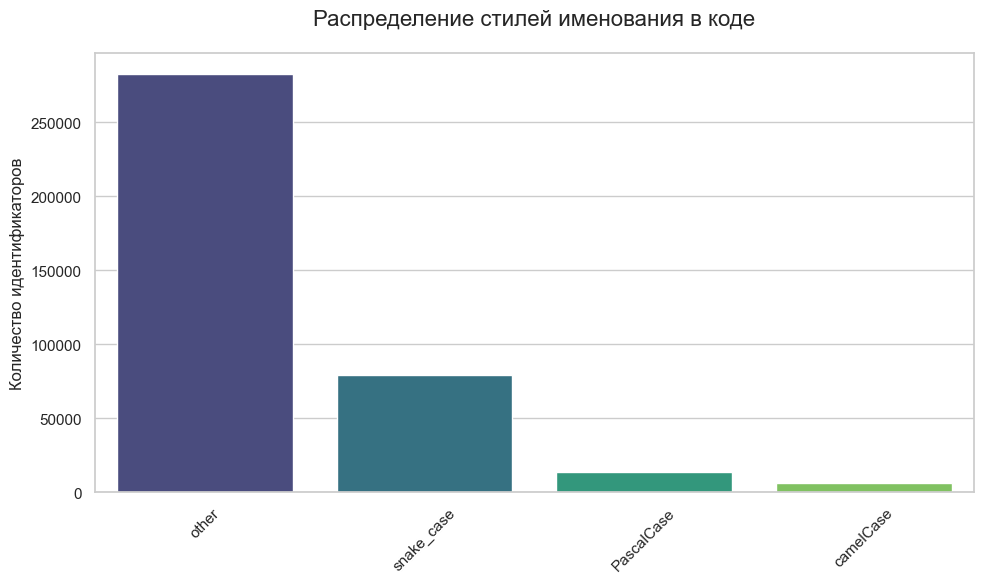


Стили именования:
-------------------------
other        →  282,960 ( 74.2%)
snake_case   →   79,301 ( 20.8%)
PascalCase   →   13,484 (  3.5%)
camelCase    →    5,836 (  1.5%)


In [18]:
# -----------------------------------------------------
# 4. АНАЛИЗ СТИЛЕЙ ИМЕНОВАНИЯ
# -----------------------------------------------------

print("\n→ Анализ стилей именования...")

# Фильтруем: только идентификаторы и не ключевые слова
identifiers = [
    t for t in all_tokens 
    if re.match(r'^[a-zA-Z_][a-zA-Z0-9_]*$', t) 
    and not keyword.iskeyword(t)
]

print(f"Найдено идентификаторов: {len(identifiers):,}")

# Классифицируем
style_counts = Counter(detect_naming_style(idf) for idf in identifiers)

# Визуализация
if style_counts:
    plt.figure(figsize=(10, 6))
    styles = list(style_counts.keys())
    counts = list(style_counts.values())
    
    sns.barplot(x=styles, y=counts, palette="viridis")
    plt.title("Распределение стилей именования в коде", fontsize=16, pad=20)
    plt.ylabel("Количество идентификаторов")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("\nСтили именования:")
    print("-" * 25)
    for style, cnt in style_counts.most_common():
        pct = cnt / len(identifiers) * 100
        print(f"{style:<12} → {cnt:>8,} ({pct:5.1f}%)")
else:
    print("Не найдено идентификаторов для анализа.")

In [9]:
# =====================================================
# 5. СТРУКТУРНЫЙ АНАЛИЗ
# =====================================================

In [19]:
import ast
from collections import defaultdict, Counter
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

In [20]:
# -----------------------------------------------------
# ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ
# -----------------------------------------------------

def get_ast_node_types(code: str):
    """
    Извлекает все типы узлов AST из кода.
    Возвращает список строк (имён классов узлов).
    """
    node_types = []
    try:
        tree = ast.parse(code)
        for node in ast.walk(tree):
            node_types.append(type(node).__name__)
    except Exception:
        pass  # Игнорируем некорректный код
    return node_types

def get_max_ast_depth(code: str):
    """
    Возвращает максимальную глубину AST дерева.
    """
    max_depth = 0
    
    def visit(node, depth=1):
        nonlocal max_depth
        max_depth = max(max_depth, depth)
        for child in ast.iter_child_nodes(node):
            visit(child, depth + 1)
    
    try:
        tree = ast.parse(code)
        visit(tree)
    except Exception:
        pass
    return max_depth


In [21]:
# -----------------------------------------------------
# СБОР ДАННЫХ
# -----------------------------------------------------

# Датасеты для анализа
datasets_to_analyze = {
    "CodeSearchNet (Python)": "codesearchnet_python",
    "CodeXGLUE (Code→Text)": "codexglue_code_to_text",
    "HumanEval": "humaneval",
}

all_node_types = []
all_depths = []

print("→ Сбор AST-информации из трёх датасетов...\n")

for label, name in datasets_to_analyze.items():
    if name not in datasets_config:
        print(f"⚠️ Пропущен: {label} (нет в datasets_config)")
        continue
        
    cfg = datasets_config[name]
    dataset = cfg["dataset"]
    max_n = min(3000, cfg["max_examples_loc"])  # ограничим для скорости
    
    # Убедимся, что не выходим за пределы датасета
    actual_max = min(max_n, len(dataset))
    iterator = dataset.take(actual_max) if hasattr(dataset, "take") \
        else dataset.select(range(actual_max))
    
    print(f"  Обрабатываю {label} ({actual_max} примеров)...")
    
    for example in tqdm(iterator, desc=label, leave=False):
        code = get_code_from_example(example)  # используем твою функцию!
        if not code or len(code) < 20:
            continue
            
        # Собираем типы узлов
        node_types = get_ast_node_types(code)
        all_node_types.extend(node_types)
        
        # Собираем глубину
        depth = get_max_ast_depth(code)
        if depth > 0:
            all_depths.append(depth)

print(f"\n✅ Всего собрано {len(all_node_types):,} узлов AST из {len(all_depths)} примеров.\n")


→ Сбор AST-информации из трёх датасетов...

  Обрабатываю CodeSearchNet (Python) (3000 примеров)...


CodeSearchNet (Python):   0%|          | 0/3000 [00:00<?, ?it/s]

  Обрабатываю CodeXGLUE (Code→Text) (3000 примеров)...


CodeXGLUE (Code→Text):   0%|          | 0/3000 [00:00<?, ?it/s]

  Обрабатываю HumanEval (164 примеров)...


HumanEval:   0%|          | 0/164 [00:00<?, ?it/s]


✅ Всего собрано 616,362 узлов AST из 5973 примеров.



ТОП-20 ТИПОВ УЗЛОВ AST:
------------------------------
 1. Load                 →  165,063
 2. Name                 →  138,406
 3. Attribute            →   41,386
 4. Constant             →   39,397
 5. Call                 →   39,040
 6. Store                →   28,836
 7. Assign               →   20,830
 8. arg                  →   18,102
 9. Expr                 →   12,121
10. If                   →   10,904
11. keyword              →    9,089
12. Subscript            →    7,555
13. Compare              →    7,507
14. Return               →    7,480
15. arguments            →    6,809
16. FunctionDef          →    6,481
17. Module               →    5,973
18. BinOp                →    5,549
19. Tuple                →    4,375
20. UnaryOp              →    2,876


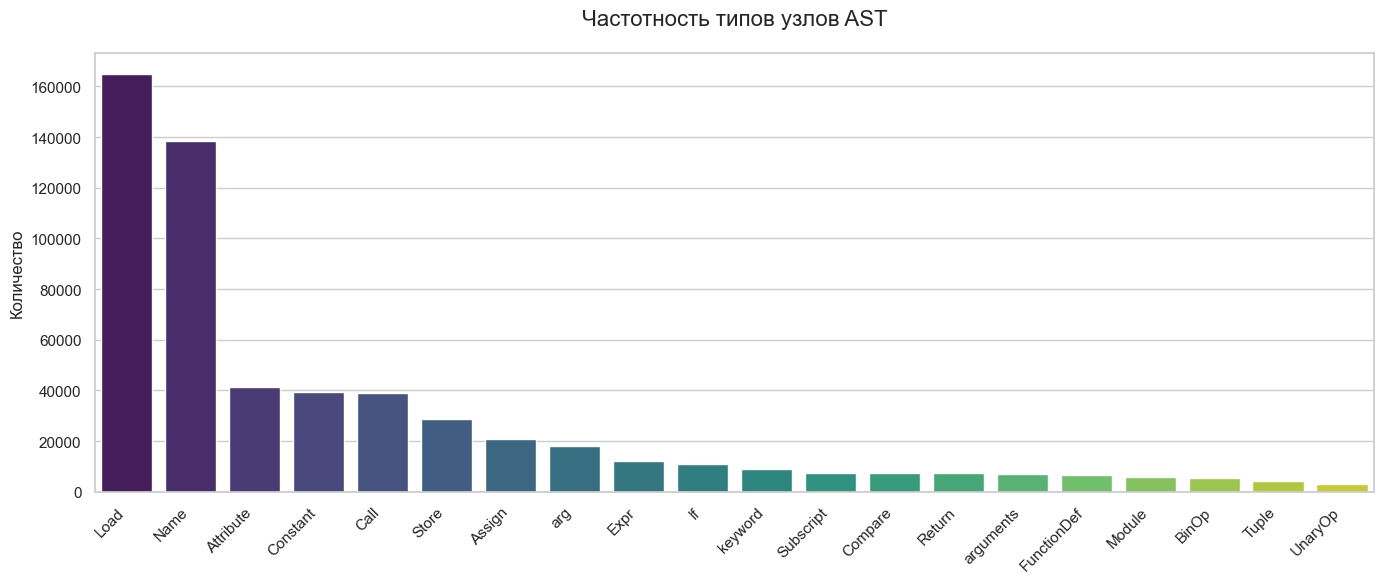

In [22]:
# -----------------------------------------------------
# 1. ЧАСТОТА ТИПОВ УЗЛОВ AST
# -----------------------------------------------------

node_freq = Counter(all_node_types)
top_nodes = node_freq.most_common(20)  # 20 самых частых

print("ТОП-20 ТИПОВ УЗЛОВ AST:")
print("-" * 30)
for i, (node_type, cnt) in enumerate(top_nodes, 1):
    print(f"{i:2}. {node_type:<20} → {cnt:>8,}")

# Визуализация: Bar Plot
plt.figure(figsize=(14, 6))
nodes, counts = zip(*top_nodes)
sns.barplot(x=list(nodes), y=list(counts), palette="viridis")
plt.title("Частотность типов узлов AST", fontsize=16, pad=20)
plt.ylabel("Количество")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

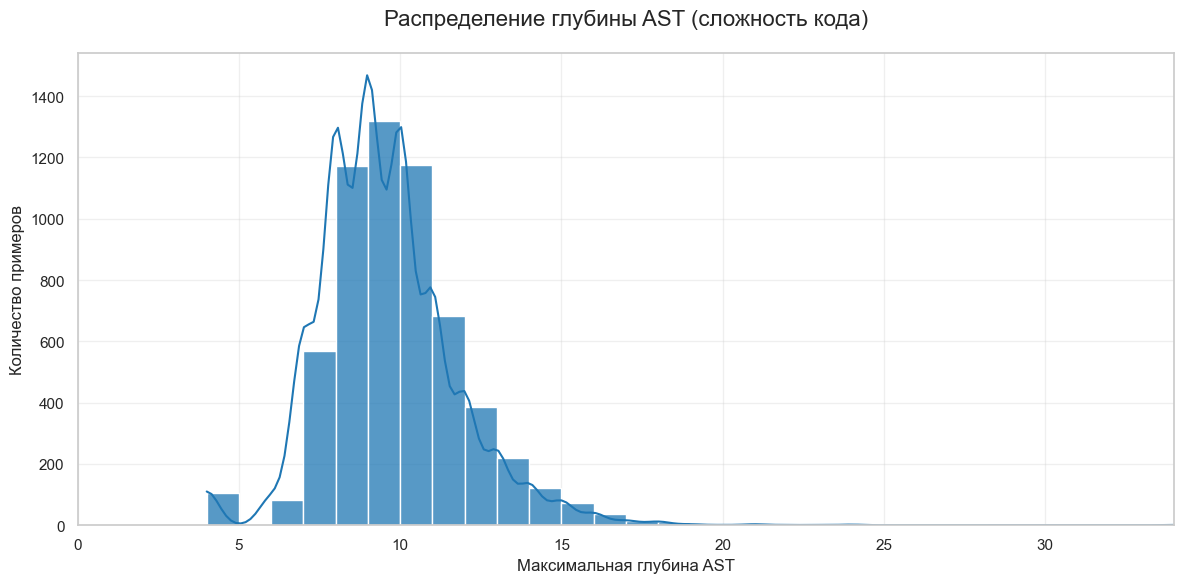


СТАТИСТИКА ГЛУБИНЫ AST:
--------------------------------------------------
Примеров        →       5973
Минимум         →          4
Максимум        →         34
Среднее         →        9.5
Медиана         →        9.0
95% перцентиль  →       13.0
99% перцентиль  →       16.0
--------------------------------------------------


In [24]:
# -----------------------------------------------------
# 2. РАСПРЕДЕЛЕНИЕ ГЛУБИНЫ AST (СЛОЖНОСТЬ КОДА)
# -----------------------------------------------------

if all_depths:
    plt.figure(figsize=(12, 6))
    sns.histplot(all_depths, bins=30, kde=True, color="#1f77b4", alpha=0.75)
    plt.title("Распределение глубины AST (сложность кода)", fontsize=16, pad=20)
    plt.xlabel("Максимальная глубина AST")
    plt.ylabel("Количество примеров")
    plt.xlim(0, max(all_depths))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Статистика
    df_depths = pd.DataFrame({"depth": all_depths})
    stats = {
        "Примеров": len(df_depths),
        "Минимум": df_depths["depth"].min(),
        "Максимум": df_depths["depth"].max(),
        "Среднее": df_depths["depth"].mean(),
        "Медиана": df_depths["depth"].median(),
        "95% перцентиль": df_depths["depth"].quantile(0.95),
        "99% перцентиль": df_depths["depth"].quantile(0.99),
    }
    
    print("\nСТАТИСТИКА ГЛУБИНЫ AST:")
    print("-" * 50)
    for key, val in stats.items():
        if isinstance(val, float):
            print(f"{key:<15} → {val:>10.1f}")
        else:
            print(f"{key:<15} → {val:>10}")
    print("-" * 50)
else:
    print("Не удалось собрать данные о глубине AST.")

In [10]:
# =====================================================
# 6. АНАЛИЗ ЗАГРЯЗНЕНИЯ И КАЧЕСТВА ДАННЫХ
# =====================================================

In [11]:
# =====================================================
# 7. АНАЛИЗ ДЛЯ КОНКРЕТНОЙ ЗАДАЧИ
# =====================================================